In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58f84000 @  0x7f0bf2c9c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import numpy as np
import random
from scipy.ndimage.filters import gaussian_filter
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

device = "cuda" if torch.cuda.is_available() else "cpu"

class NormalDistributionCollection(object):
    def __init__(self, resolution, var=0.07):
        self.gaussians = torch.stack([self.normal_distribution(resolution, index.item() / resolution, var) for index in np.arange(resolution)])

    @staticmethod
    def normal_distribution(n, mean, var=0.05):
      x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
      x = x / np.max(x)
      return torch.tensor(x).float()

    @staticmethod
    def to_pdf(frames):
        element_count = np.prod(frames.shape)
        frames_shape = frames.shape
        frames_view = frames.contiguous().view((element_count,))
        frames_pdf = torch.stack([NormalDistributionCollection.normal_distribution(resolution, mean.item()) for mean in frames_view])
        frames_pdf = frames_pdf.view(frames_shape[:-1] + (frames_shape[-1] * resolution, ))
        return frames_pdf


def generate_frames1(width, height):
    frames = []
    for _ in range(100):
        frame = np.zeros((width, height))
        rr, cc, val = line_aa(random.randint(0, height-1), random.randint(0, width-1), random.randint(0, height-1), random.randint(0, width-1))
        frame[rr, cc] = val
        frame=gaussian_filter(frame, 0.5)
        frames.append(frame)

    return torch.as_tensor(frames).to(device)

def generate_frames(width, height):
    return torch.as_tensor([[[0, 0], [1, 1]], [[1, 1], [0, 0]]])
    
def show_image(image, vmin=None, vmax=None, title=None, print_values=False):
    #print("image ", image.shape)
    fig, ax1 = plt.subplots(figsize=(6, 2))
    if title:
        plt.title(title)
    #i = image.reshape((height, width))
    #print("i ", i.shape)
    ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
    plt.show()
    if print_values:
        print(image)
        
# Assume input (samples, feature maps, height, width) and that 
# features maps is a perfect squere, e.g. 9, of an integer 'a', e.g. 3 in this case
# Output (samples, height * a, width * a)
def flatten_feature_maps(f):
    s = f.shape
    f = f.permute(0, 2, 3, 1) # move features to the end
    s = f.shape
    a = int(s[3] ** 0.5)  # feature maps are at pos 3 now that we want to first split into a square of size (a X a)
    assert a * a == s[3], "Feature map count must be a perfect square"
    f = f.view(s[0], s[1], s[2], a, a)
    f = f.permute(0, 1, 3, 2, 4).contiguous() # frame count, height, sqr(features), width, sqr(features)
    s = f.shape
    f = f.view(s[0], s[1] * s[2], s[3] * s[4]) # each point becomes a square of features
    return f, a

class Encoder(torch.nn.Module): 
  
    def __init__(self, a, resolution, kernel_size=4, stride=1):
        super().__init__()
        out_channels = a * a
        self.a = a
        self.e1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(kernel_size, kernel_size*resolution), stride=(stride, stride*resolution)).to(device)
        self.bn1 = nn.BatchNorm2d(out_channels).to(device)
        #self.pool1 = nn.MaxPool2d(2).to(device)
        self.tanh = nn.Tanh().to(device)

    def forward(self, x, flatten=True):
        x = x[:, None, :, :]  # assume 1 feature
        x = self.e1(x)
        x = self.bn1(x)
        #x = self.pool1(x)
        x = self.tanh(x)
        
        if flatten:
          x, _ = flatten_feature_maps(x)
        return x

class Decoder(torch.nn.Module): 
  
    def __init__(self, a, output_height, output_width, resolution):
        super().__init__() 
        self.a = a

        self.output_height = output_height
        self.output_width = output_width
        self.resolution = resolution

        #self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.d1 = nn.ConvTranspose2d(1, 1, a, stride=a).to(device)
        self.linear = None
  
    def forward(self, z):
        assert z.shape[-2] % self.a == 0, f"input height must be multiple of {self.a}"
        assert z.shape[-1] % self.a == 0, f"input width must be multiple of {self.a}"

        z = z[:, None, :, :]  # assume 1 feature
        z = self.d1(z)
        z = torch.nn.functional.interpolate(z, (self.output_height, self.output_width * self.resolution))
        #z = self.tanh(z)
        #print(f"z.shape = {z.shape}")
        #print(f"self.output_height = {self.output_height}")
        #print(f"self.output_width * self.resolution = {self.output_width * self.resolution}")

        #s = z.shape
        #z = z.view(s[0], s[1] * s[2] * s[3])
        
        #if self.linear is None:
        #    self.linear = nn.Linear(z.shape[-1], self.output_height * self.output_width * self.resolution).to(device)
        
        #z = self.linear(z)
        z = z.view(z.shape[0], self.output_height, self.output_width * self.resolution)
        z = self.relu(z)

        return z

class Network(torch.nn.Module):
    
    def __init__(self, height, width, resolution, out_channels, kernel_size=4, stride=1):
        super().__init__()
        self.a = int(out_channels**0.5)
        self.encoder = Encoder(a=a, resolution=resolution, kernel_size=kernel_size, stride=stride).to(device)
        self.decoder = Decoder(a=a, output_height=height, output_width=width, resolution=resolution).to(device)
        self.hidden_state = None
        
    def forward(self, x):
        x = self.hidden_state = self.encoder(x)
        x = self.decoder(x)
        return x
    
class Layer(object):
    def __init__(self):
        self.hidden_state = "uninitialized"
        self.model = None
    
    def forward(self, frames, resolution, out_channels=10, epochs=1000, kernel_size=4, stride=1):
        _, height, width = frames.shape
        
        frames_pdf = NormalDistributionCollection.to_pdf(frames).to(device)
        print("frames_pdf ", frames_pdf.shape)
        if self.model is None:
          self.model = Network(height, width, resolution, out_channels, kernel_size=kernel_size, stride=stride).to(device)
        
        out = self.model(frames_pdf)
        print("out shape = ", out.shape)
        
        for index in range(10, 11):
            show_image(frames[index].detach().cpu().numpy(), title=f"frame {index} : {frames[index].shape}", vmin=0, vmax=1)
            show_image(frames_pdf[index].detach().cpu().numpy(), title=f"frame pdf {index} : {frames_pdf[index].shape}", vmin=0, vmax=1)
            show_image(out[index].detach().cpu().numpy(), title=f"out {index} : {out[index].shape}", vmin=0, vmax=1)
            
        return frames_pdf, out
      
    def train(self, frames, resolution, out_channels=10, epochs=1000, kernel_size=4, stride=1):
        print("--------------------------------")
        print("Training with frames ", frames.shape)

        frames_pdf, out = self.forward(frames, resolution, out_channels=10, epochs=1000, kernel_size=4, stride=1)
        optimizer = optim.Adam(self.model.parameters(), lr=1e-5)
        for epoch in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            out1 = self.model(frames_pdf)
            loss = F.mse_loss(out1, frames_pdf)
            if (epoch + 1) % int(epochs/10) == 0:
                print(f"epoch {epoch}:\tloss {loss}")
            loss.backward()
            optimizer.step()

        for index in range(10, 11):
            show_image(frames[index].detach().cpu().numpy(), title=f"frame {index} : {frames[index].shape}", vmin=0, vmax=1)
            show_image(frames_pdf[index].detach().cpu().numpy(), title=f"frame pdf {index} : {frames_pdf[index].shape}", vmin=0, vmax=1)
            show_image(out1[index].detach().cpu().numpy(), title=f"out {index} : {out1[index].shape}", vmin=0, vmax=1)

        self.hidden_state = self.model.hidden_state

        # show info
        print("frames_pdf ", frames_pdf.shape)
        h = self.model.hidden_state
        print("h ", h.shape)
        

def sample_from_frame_pdf(mu_bar):
    assert len(mu_bar.shape) == 3
    
    # reshape mu_pdf from (frame count, height, width*resolution) into (frame count*height*width, resolution)
    s = mu_bar.shape
    mu_pdf = mu_bar.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = mu_pdf.shape
    mu_pdf = mu_pdf.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (frame count*height*width, 1)
    sample = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in mu_pdf])
    
    # reshape back into (frame count, height, width)
    sample = sample.view(s[0], s[1], s[2])

    return sample
    
def sample_from_pdf(mu_pdf):
    assert mu_pdf.shape == (resolution, )

    pk = mu_pdf.copy()
    xk = np.arange(resolution)
    pk[pk<0] = 0
    sum_pk = sum(pk)
    if sum(pk) > 0:
        pk = pk / sum_pk
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        value = custm.rvs(size=1) / resolution
        # apply scale (conflates value and confidence!)
        value = value * sum_pk
        return value
    else:
        return [0]

def averaged_sample_from_frame_pdf(pdf, count=10):
    mu_bar_sampled_array = torch.stack([sample_from_frame_pdf(pdf) for i in range(count)])
    return mu_bar_sampled_array.mean(dim=0)


--------------------------------
Training with frames  torch.Size([100, 8, 8])
frames_pdf  torch.Size([100, 8, 64])
out shape =  torch.Size([100, 8, 64])


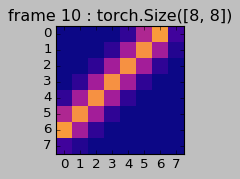

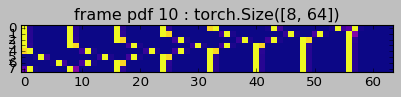

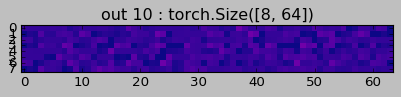

epoch 999:	loss 0.11379333585500717
epoch 1999:	loss 0.11148398369550705
epoch 2999:	loss 0.10971082746982574
epoch 3999:	loss 0.10826850682497025
epoch 4999:	loss 0.1070367619395256
epoch 5999:	loss 0.10598403960466385
epoch 6999:	loss 0.10508465766906738
epoch 7999:	loss 0.10425020009279251
epoch 8999:	loss 0.10349298268556595
epoch 9999:	loss 0.10281136631965637


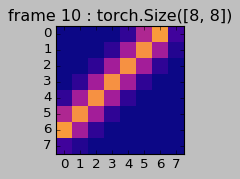

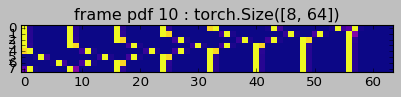

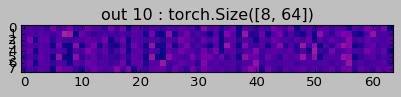

frames_pdf  torch.Size([100, 8, 64])
h  torch.Size([100, 20, 20])


In [17]:
# Layer 1 autoencoder
resolution = 8
frames1 = generate_frames1(8, 8)
layer1 = Layer()
epochs = 10000 if device == "cuda" else 5000
a = 4

layer1.train(frames1, resolution, out_channels=a**2, epochs=epochs, kernel_size=3, stride=1)

frames_pdf  torch.Size([100, 8, 64])
out shape =  torch.Size([100, 8, 64])


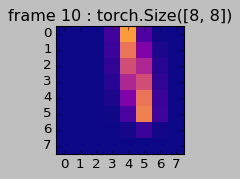

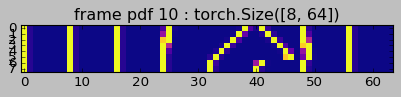

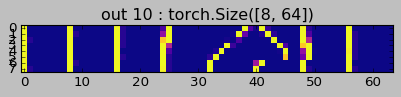

--------------------------------
Training with frames  torch.Size([100, 20, 20])
frames_pdf  torch.Size([100, 20, 160])
out shape =  torch.Size([100, 20, 160])


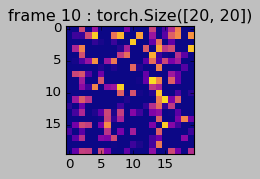

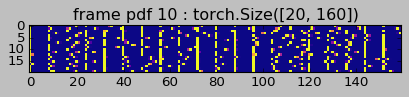

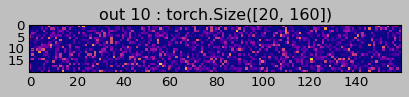

epoch 999:	loss 0.02821941487491131
epoch 1999:	loss 0.019353067502379417
epoch 2999:	loss 0.017669960856437683
epoch 3999:	loss 0.01735563576221466
epoch 4999:	loss 0.01731124334037304
epoch 5999:	loss 0.017305579036474228
epoch 6999:	loss 0.017305448651313782
epoch 7999:	loss 0.017305444926023483
epoch 8999:	loss 0.017305444926023483
epoch 9999:	loss 0.017305444926023483


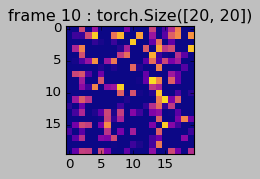

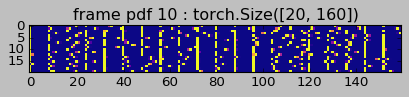

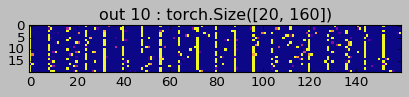

frames_pdf  torch.Size([100, 20, 160])
h  torch.Size([100, 34, 34])


In [4]:
# Layer 2 autoencoder
layer2 = Layer()
layer1.forward(frames1, resolution=resolution)
f = layer1.hidden_state
a = 2
layer2.train(f, resolution, out_channels=a**2, epochs=epochs, kernel_size=3*layer1.model.encoder.a, stride=layer1.model.encoder.a)

mu1 shape torch.Size([90, 8, 8])


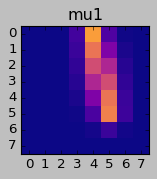

mu_pdf1 shape torch.Size([90, 8, 64])


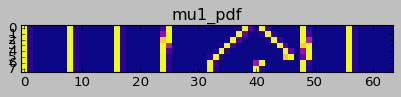

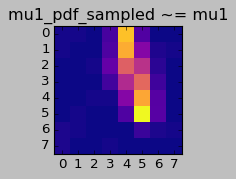

mu1_bar shape torch.Size([90, 8, 64])


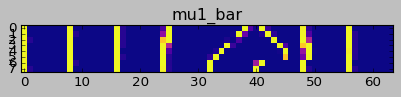

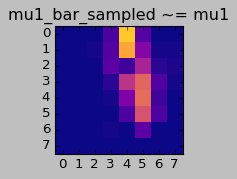

mu2 shape =  torch.Size([90, 20, 20])
mu2 shape torch.Size([90, 20, 20])


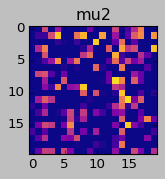

mu_pdf2 shape torch.Size([90, 20, 160])


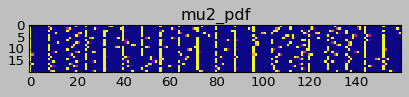

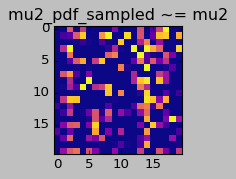

mu2_bar shape torch.Size([90, 20, 160])


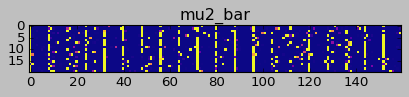

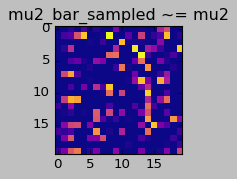

mu2_bar_sampled shape =  torch.Size([90, 20, 20])
mu_bar  torch.Size([90, 8, 64])


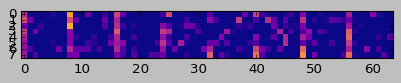

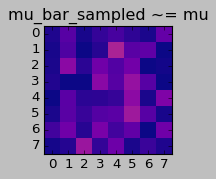

In [5]:
def forward(mu, layer, layer_index):
    print(f"mu{layer_index} shape {mu.shape}")
    show_image(mu[0], title=f"mu{layer_index}", vmin=vmin, vmax=vmax)
    
    mu_pdf = NormalDistributionCollection.to_pdf(mu).to(device)
    print(f"mu_pdf{layer_index} shape {mu_pdf.shape}")
    show_image(mu_pdf[0], title=f"mu{layer_index}_pdf", vmin=vmin, vmax=vmax)
    
    mu_pdf_sampled = averaged_sample_from_frame_pdf(mu_pdf.detach())[0]
    show_image(mu_pdf_sampled, title=f"mu{layer_index}_pdf_sampled ~= mu{layer_index}", vmin=vmin, vmax=vmax)

    # Layer
    #h = layer.model.encoder(mu_pdf)
    #print(f"h{layer_index} shape {h.shape}")
    mu_bar = layer.model(mu_pdf)
    print(f"mu{layer_index}_bar shape {mu_bar.shape}")
    show_image(mu_bar[0].detach().cpu().numpy(), title=f"mu{layer_index}_bar", vmin=vmin, vmax=vmax)

    mu_bar_sampled = averaged_sample_from_frame_pdf(mu_bar.detach())
    show_image(mu_bar_sampled[0], title=f"mu{layer_index}_bar_sampled ~= mu{layer_index}", vmin=vmin, vmax=vmax)
    return mu_bar_sampled

image_index = 10
vmin = 0
vmax = 1
mu1 = frames1[image_index:]


# Layer 1
forward(mu1, layer1, 1)    

# Layer 2
mu1_pdf = NormalDistributionCollection.to_pdf(mu1).to(device)
layer1.model.hidden_state = None
layer1.model(mu1_pdf)
mu2 = layer1.model.hidden_state.detach().clone()
print("mu2 shape = ", mu2.shape)
mu2_bar_sampled = forward(mu2, layer2, 2)
print("mu2_bar_sampled shape = ", mu2_bar_sampled.shape)

# mu2_bar_sampled decoded by layer 1 should reproduce mu1
mu_bar = layer1.model.decoder(mu2_bar_sampled.to(device)).detach()
print("mu_bar ", mu_bar.shape)
show_image(mu_bar[0], vmin=vmin, vmax=vmax)
mu_bar_sampled = averaged_sample_from_frame_pdf(mu_bar)[0]
show_image(mu_bar_sampled, title=f"mu_bar_sampled ~= mu", vmin=vmin, vmax=vmax)


In [0]:
# show_image(averaged_sample_from_frame_pdf(mu_bar[0].unsqueeze(dim=0), 20)[0], title=f"mu_bar_sampled_array_mean ~= mu", vmin=vmin, vmax=vmax)

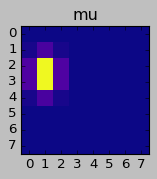

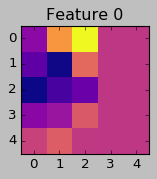

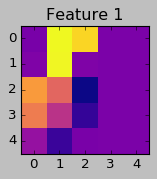

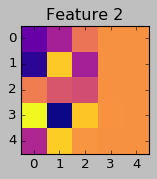

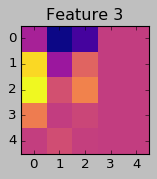

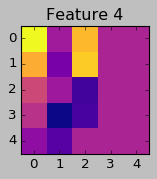

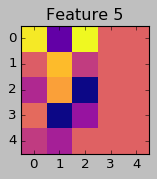

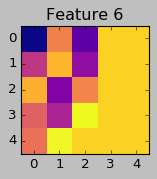

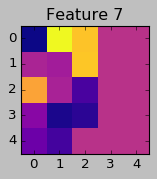

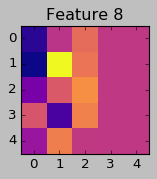

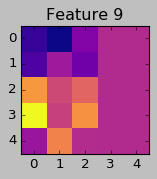

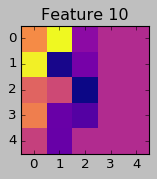

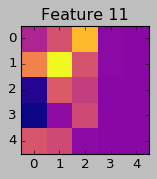

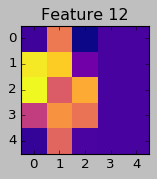

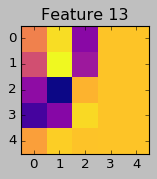

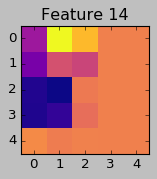

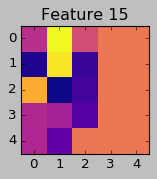

In [7]:
index = 11
mu = frames1[index].unsqueeze(dim=0)
show_image(mu[0].detach(), title=f"mu")

mu_pdf = NormalDistributionCollection.to_pdf(mu).to(device)
x = layer1.model.encoder.forward(mu_pdf, flatten=False)
for i in range(layer1.model.encoder.a ** 2):
  show_image(x[0][i].detach(), title=f"Feature {i}")

